# Weather Data Acquisation

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_style('whitegrid')
%matplotlib inline

## 1. Fetch Weather Data from Open-Meteo

Open-Meteo Historical Weather API (free, no API key required)

NYC coordinates: 40.7128° N, 74.0060° W

In [2]:
# NYC coordinates (midpoint)
LAT, LON = 40.7128, -74.0060

# API endpoint
url = "https://archive-api.open-meteo.com/v1/archive"

# Parameters
params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": "2022-01-01",
    "end_date": "2025-11-27",
    "hourly": "precipitation,visibility",
    "timezone": "America/New_York"
}

print("Fetching weather data from Open-Meteo...")
print(f"  Location: NYC ({LAT}, {LON})")
print(f"  Date range: {params['start_date']} to {params['end_date']}")
print(f"  Variables: {params['hourly']}")

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    print(f"\n✓ Weather data fetched successfully!")
    print(f"  Status code: {response.status_code}")
else:
    print(f"\n✗ Error fetching data: {response.status_code}")
    print(response.text)
    raise Exception("Failed to fetch weather data")

Fetching weather data from Open-Meteo...
  Location: NYC (40.7128, -74.006)
  Date range: 2022-01-01 to 2025-11-27
  Variables: precipitation,visibility

✓ Weather data fetched successfully!
  Status code: 200


## 2. Parse JSON Response to DataFrame

In [4]:
# Parse hourly data
weather = pd.DataFrame({
    'datetime': pd.to_datetime(data['hourly']['time']),
    'precipitation': data['hourly']['precipitation'],
    'visibility': data['hourly']['visibility']
})

print(f"Weather data shape: {weather.shape}")
print(f"\nFirst 5 rows:")
weather.head()

Weather data shape: (34248, 3)

First 5 rows:


,datetime,precipitation,visibility
0,2022-01-01 00:00:00,0.0,None
1,2022-01-01 01:00:00,0.0,None
2,2022-01-01 02:00:00,0.0,None
3,2022-01-01 03:00:00,0.1,None
4,2022-01-01 04:00:00,0.1,None


## 3. Extract Date and Hour

In [5]:
# Extract date and hour for merging with crash panel
weather['date'] = weather['datetime'].dt.date
weather['hour'] = weather['datetime'].dt.hour

print("✓ Extracted date and hour")
print(f"\nDate range: {weather['date'].min()} to {weather['date'].max()}")
print(f"Total hours: {len(weather):,}")
print(f"\nSample rows:")
weather[['datetime', 'date', 'hour', 'precipitation', 'visibility']].head(10)

✓ Extracted date and hour

Date range: 2022-01-01 to 2025-11-27
Total hours: 34,248

Sample rows:


,datetime,date,hour,precipitation,visibility
0,2022-01-01 00:00:00,2022-01-01,0,0.0,None
1,2022-01-01 01:00:00,2022-01-01,1,0.0,None
2,2022-01-01 02:00:00,2022-01-01,2,0.0,None
3,2022-01-01 03:00:00,2022-01-01,3,0.1,None
4,2022-01-01 04:00:00,2022-01-01,4,0.1,None
5,2022-01-01 05:00:00,2022-01-01,5,1.1,None
6,2022-01-01 06:00:00,2022-01-01,6,1.1,None
7,2022-01-01 07:00:00,2022-01-01,7,0.5,None
8,2022-01-01 08:00:00,2022-01-01,8,0.7,None
9,2022-01-01 09:00:00,2022-01-01,9,0.7,None


## 4. Create Rain Flag (Binary Treatment)

**Threshold:** precipitation > 0.1 mm (light rain)

In [6]:
# Define rain threshold
RAIN_THRESHOLD = 0.1  # mm

# Create rain_flag
weather['rain_flag'] = (weather['precipitation'] > RAIN_THRESHOLD).astype(int)

print(f"✓ Rain flag created (threshold: {RAIN_THRESHOLD} mm)")
print(f"\nRain distribution:")
print(weather['rain_flag'].value_counts())
print(f"\nPercentage of hours with rain: {weather['rain_flag'].mean() * 100:.2f}%")

# Check for missing values
print(f"\nMissing values:")
print(weather.isnull().sum())

✓ Rain flag created (threshold: 0.1 mm)

Rain distribution:
rain_flag
0    30563
1     3685
Name: count, dtype: int64

Percentage of hours with rain: 10.76%

Missing values:
datetime             0
precipitation        0
visibility       34248
date                 0
hour                 0
rain_flag            0
dtype: int64


## 5. Visualize Weather Data

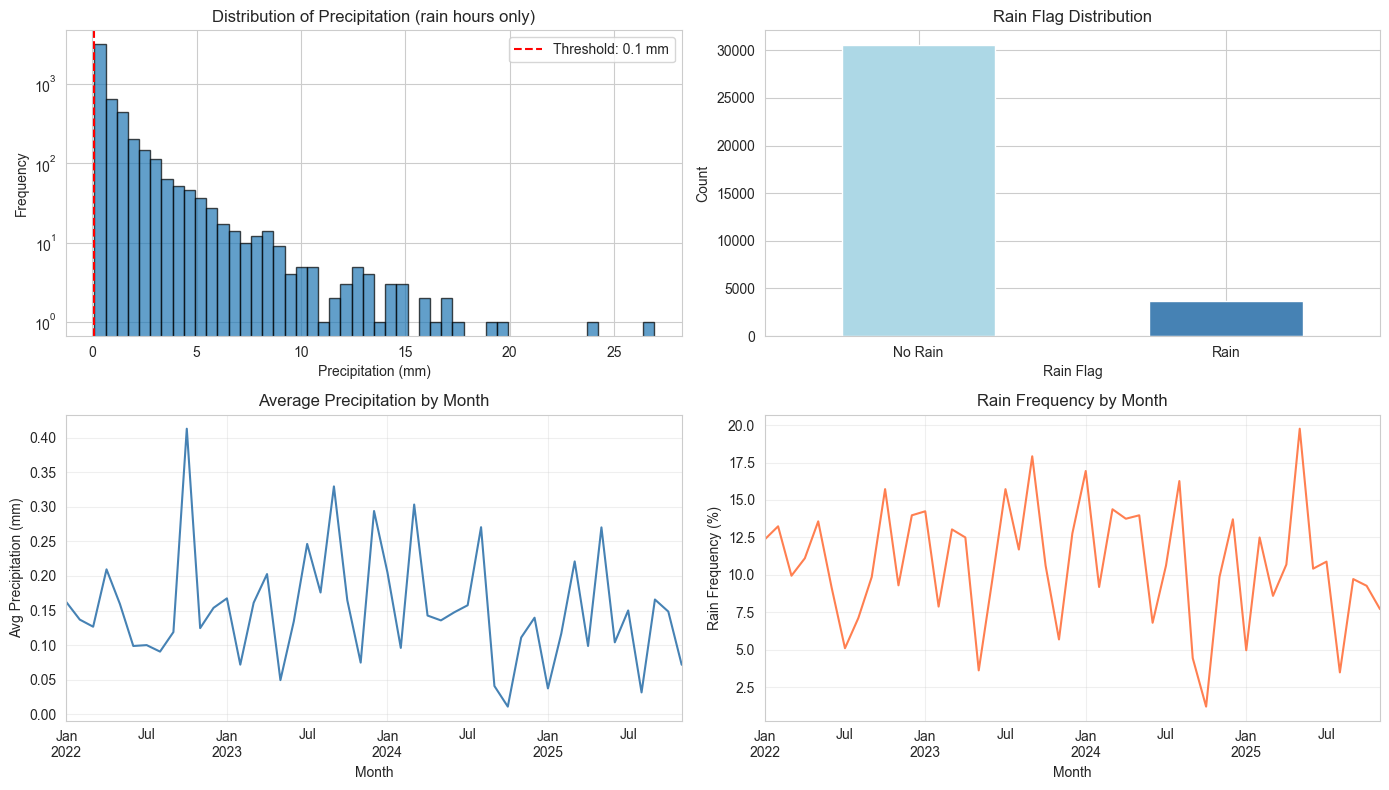

In [7]:
# Visualize precipitation and rain flag
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Precipitation distribution (log scale)
weather[weather['precipitation'] > 0]['precipitation'].hist(bins=50, ax=axes[0, 0], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Precipitation (mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Precipitation (rain hours only)')
axes[0, 0].axvline(RAIN_THRESHOLD, color='red', linestyle='--', label=f'Threshold: {RAIN_THRESHOLD} mm')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Rain flag distribution
weather['rain_flag'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'steelblue'])
axes[0, 1].set_xlabel('Rain Flag')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Rain Flag Distribution')
axes[0, 1].set_xticklabels(['No Rain', 'Rain'], rotation=0)

# Precipitation over time (monthly average)
monthly_precip = weather.groupby(weather['datetime'].dt.to_period('M'))['precipitation'].mean()
monthly_precip.plot(ax=axes[1, 0], color='steelblue')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Avg Precipitation (mm)')
axes[1, 0].set_title('Average Precipitation by Month')
axes[1, 0].grid(True, alpha=0.3)

# Rain frequency by month
monthly_rain_freq = weather.groupby(weather['datetime'].dt.to_period('M'))['rain_flag'].mean() * 100
monthly_rain_freq.plot(ax=axes[1, 1], color='coral')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Rain Frequency (%)')
axes[1, 1].set_title('Rain Frequency by Month')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Save Weather Data

In [8]:
# Select final columns
weather_final = weather[['date', 'hour', 'precipitation', 'visibility', 'rain_flag']].copy()

# Save to CSV
weather_final.to_csv('../data/nyc_weather_hourly.csv', index=False)
print(f"✓ Saved weather data to ../data/nyc_weather_hourly.csv")
print(f"  Final shape: {weather_final.shape}")

✓ Saved weather data to ../data/nyc_weather_hourly.csv
  Final shape: (34248, 5)


## 7. Weather Data Summary

In [9]:
print("=" * 60)
print("WEATHER DATA SUMMARY")
print("=" * 60)
print(f"Total hours:                 {len(weather_final):,}")
print(f"Date range:                  {weather_final['date'].min()} to {weather_final['date'].max()}")
print(f"Rain hours (rain_flag=1):    {weather_final['rain_flag'].sum():,} ({weather_final['rain_flag'].mean()*100:.2f}%)")
print(f"No rain hours (rain_flag=0): {(weather_final['rain_flag'] == 0).sum():,} ({(weather_final['rain_flag'] == 0).mean()*100:.2f}%)")
print(f"\nPrecipitation statistics (mm):")
print(weather_final['precipitation'].describe())
print(f"\nVisibility statistics (m):")
print(weather_final['visibility'].describe())
print("=" * 60)
print("\n✓ Weather data acquisition complete!")

WEATHER DATA SUMMARY
Total hours:                 34,248
Date range:                  2022-01-01 to 2025-11-27
Rain hours (rain_flag=1):    3,685 (10.76%)
No rain hours (rain_flag=0): 30,563 (89.24%)

Precipitation statistics (mm):
count    34248.000000
mean         0.152718
std          0.789474
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.900000
Name: precipitation, dtype: float64

Visibility statistics (m):
count       0
unique      0
top       NaN
freq      NaN
Name: visibility, dtype: object

✓ Weather data acquisition complete!
